# Kernel SHAP vs Tree SHAP
Experiments to understand the time complexity of SHAP approximations

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('default')
%matplotlib inline

#import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
import sklearn.datasets as ds

import datetime

import shap
shap.initjs()

import os
dp = os.environ.get('pub_data')

path = '../../../figures/'

In [2]:
# Functions
def runSHAP(n,kernel=True): 
    """
    Calculate shap values and return time taken
        n: number of SHAP values to calculate
        kernel: set False if using TreeSHAP 
    """
    
    x_sample = X[np.random.choice(X.shape[0], n, replace=True)]
    
    begin = datetime.datetime.now()
    if kernel:
        #Caculate SHAP values using KernelSHAP
        shap_values = kernelSHAP.shap_values(x_sample,l1_reg=False)
        time = datetime.datetime.now() - begin
        print("Kernel {}: ".format(n), time)
    else:
        #Caculate SHAP values using TreeSHAP
        shap_values = treeSHAP(x_sample)
        time = datetime.datetime.now() - begin
        print("Tree {}: ".format(n), time)
    
    return time

def model_properties(model):
    """Returns average depth and number of features and leaves of a random forest"""
    
    depths = []
    features = []
    leaves = []
    
    for tree in model.estimators_:
        depths.append(tree.get_depth())
        leaves.append(tree.get_n_leaves())
        n_feat = len(set(tree.tree_.feature)) -1 
        features.append(n_feat)
        
    return np.mean(depths), np.mean(features), np.mean(leaves)

### Experiment 1: Number of samples

In [3]:
# Simulate regression data
data = ds.make_regression(n_samples=10000, n_features=10, n_informative=8, n_targets=1)

y= data[1]
X = data[0]

feature_names = range(len(X))

In [4]:
# Train model
model = RandomForestRegressor(n_estimators=100,max_depth=4,random_state=0)
model.fit(X, y)

RandomForestRegressor(max_depth=4, random_state=0)

In [5]:
# Get shap estimators
kernelSHAP = shap.KernelExplainer(model.predict,shap.sample(X, 10))
treeSHAP = shap.TreeExplainer(model)

In [6]:
results = []
for n in [10,100,1000,2000,5000,10000]*3:
    # Calculate SHAP Values
    kernel_time = runSHAP(n=n)
    tree_time = runSHAP(n=n,kernel=False)
    
    result = [n,kernel_time,tree_time]
    results.append(result)
    
results_1 = pd.DataFrame(results,columns = ['n','kernelSHAP','treeSHAP'])

  0%|          | 0/10 [00:00<?, ?it/s]

Kernel 10:  0:00:00.563459
Tree 10:  0:00:00.002201


  0%|          | 0/100 [00:00<?, ?it/s]

Kernel 100:  0:00:03.991443
Tree 100:  0:00:00.010074


  0%|          | 0/1000 [00:00<?, ?it/s]

Kernel 1000:  0:00:42.753696
Tree 1000:  0:00:00.100709


  0%|          | 0/2000 [00:00<?, ?it/s]

Kernel 2000:  0:01:21.312671
Tree 2000:  0:00:00.150555


  0%|          | 0/5000 [00:00<?, ?it/s]

Kernel 5000:  0:04:38.017846
Tree 5000:  0:00:00.838282


  0%|          | 0/10000 [00:00<?, ?it/s]

Kernel 10000:  0:07:48.051865
Tree 10000:  0:00:00.747681


  0%|          | 0/10 [00:00<?, ?it/s]

Kernel 10:  0:00:00.681855
Tree 10:  0:00:00.001287


  0%|          | 0/100 [00:00<?, ?it/s]

Kernel 100:  0:00:04.078480
Tree 100:  0:00:00.008878


  0%|          | 0/1000 [00:00<?, ?it/s]

Kernel 1000:  0:00:43.278783
Tree 1000:  0:00:00.081060


  0%|          | 0/2000 [00:00<?, ?it/s]

Kernel 2000:  0:01:37.605214
Tree 2000:  0:00:00.148124


  0%|          | 0/5000 [00:00<?, ?it/s]

Kernel 5000:  0:03:25.229475
Tree 5000:  0:00:00.403604


  0%|          | 0/10000 [00:00<?, ?it/s]

Kernel 10000:  0:07:41.293157
Tree 10000:  0:00:00.819307


  0%|          | 0/10 [00:00<?, ?it/s]

Kernel 10:  0:00:00.583351
Tree 10:  0:00:00.002362


  0%|          | 0/100 [00:00<?, ?it/s]

Kernel 100:  0:00:04.924398
Tree 100:  0:00:00.008337


  0%|          | 0/1000 [00:00<?, ?it/s]

Kernel 1000:  0:00:39.904813
Tree 1000:  0:00:00.073530


  0%|          | 0/2000 [00:00<?, ?it/s]

Kernel 2000:  0:01:28.520254
Tree 2000:  0:00:00.182792


  0%|          | 0/5000 [00:00<?, ?it/s]

Kernel 5000:  0:03:27.839490
Tree 5000:  0:00:00.374523


  0%|          | 0/10000 [00:00<?, ?it/s]

Kernel 10000:  0:06:33.445925
Tree 10000:  0:00:00.823046


0    312.592308
1    476.191733
2    493.297183
3    555.461686
4    427.544520
5    553.461141
Name: n, dtype: float64


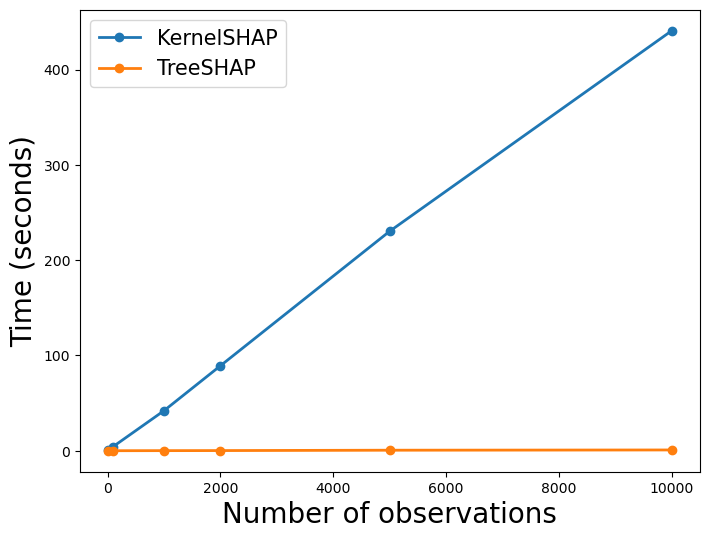

In [8]:
# Find average run time
avg_1 = results_1.groupby(by='n',as_index=False).mean()

k_sec = [t.total_seconds() for t in avg_1['kernelSHAP']]
t_sec = [t.total_seconds() for t in avg_1['treeSHAP']]
n = avg_1['n']

# Proportional run time
print((k_sec/n)/(t_sec/n))

# Plot run time by number of observations
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(8,6))

plt.plot(n, k_sec, linestyle='-', linewidth=2,marker='o',label = 'KernelSHAP')
plt.plot(n, t_sec, linestyle='-', linewidth=2,marker='o',label = 'TreeSHAP')

plt.ylabel('Time (seconds)',size=20)
plt.xlabel('Number of observations',size=20)
plt.legend(fontsize=15)

plt.savefig(path.format('n_observations_1.png'),dpi=100,bbox_inches='tight')

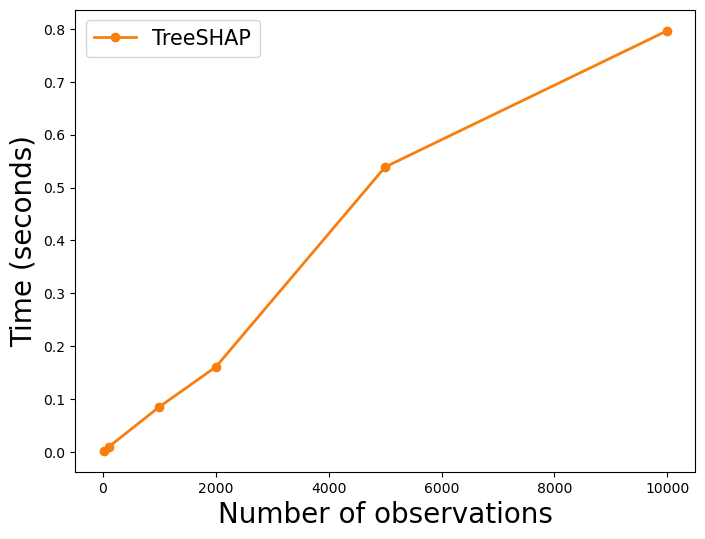

In [9]:
# Number of observations
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(8,6))

plt.plot(n, t_sec, linestyle='-', color='#F87F0E',linewidth=2,marker='o',label = 'TreeSHAP')

plt.ylabel('Time (seconds)',size=20)
plt.xlabel('Number of observations',size=20)
plt.legend(fontsize=15)

plt.savefig(path.format('n_observations_2.png'),dpi=100,bbox_inches='tight')

### Experiment 2: number of features
    

In [12]:
results = []

for n_features, n_informative in zip([2,4,6,8,10,12,13,14,16,18,20]*3,[2,4,6,8,10,12,13,14,16,18,20]*3):
    
    # Simulate regression data
    data = ds.make_regression(n_samples=10000, n_features=n_features, n_informative=n_informative, n_targets=1,noise=0.1)

    y= data[1]
    X = data[0]

    feature_names = range(len(X))

    # Train model
    model = RandomForestRegressor(n_estimators=100,max_depth=10,random_state=0)
    model.fit(X, y)
    
    # get model properties
    avg_depth, avg_feat, avg_leaves = model_properties(model)
    
    # Get shap estimators
    kernelSHAP = shap.KernelExplainer(model.predict,shap.sample(X, 10))
    treeSHAP = shap.TreeExplainer(model)
    
    # Calculate SHAP values
    kernel_time = runSHAP(n=100)
    tree_time = runSHAP(n=100,kernel=False)
    
    result = [n_features, avg_depth, avg_feat, avg_leaves, kernel_time,tree_time]
    results.append(result)

results_2 = pd.DataFrame(results,columns = ['n_features','avg_depth', 'avg_feat', 'avg_leaves','kernelSHAP','treeSHAP'])



  0%|          | 0/100 [00:00<?, ?it/s]

Kernel 100:  0:00:00.575029
Tree 100:  0:00:00.392890


  0%|          | 0/100 [00:00<?, ?it/s]

Kernel 100:  0:00:00.779340
Tree 100:  0:00:00.616860


  0%|          | 0/100 [00:00<?, ?it/s]

Kernel 100:  0:00:01.075500
Tree 100:  0:00:00.743020


  0%|          | 0/100 [00:00<?, ?it/s]

Kernel 100:  0:00:02.311762
Tree 100:  0:00:01.303481


  0%|          | 0/100 [00:00<?, ?it/s]

Kernel 100:  0:00:05.908635
Tree 100:  0:00:01.183961


  0%|          | 0/100 [00:00<?, ?it/s]

Kernel 100:  0:00:11.646808
Tree 100:  0:00:01.960565


  0%|          | 0/100 [00:00<?, ?it/s]

Kernel 100:  0:00:11.916998
Tree 100:  0:00:01.522622


  0%|          | 0/100 [00:00<?, ?it/s]

Kernel 100:  0:00:16.648594
Tree 100:  0:00:01.587083


  0%|          | 0/100 [00:00<?, ?it/s]

Kernel 100:  0:00:20.406791
Tree 100:  0:00:02.042501


  0%|          | 0/100 [00:00<?, ?it/s]

Kernel 100:  0:00:17.898821
Tree 100:  0:00:02.104673


  0%|          | 0/100 [00:00<?, ?it/s]

Kernel 100:  0:00:16.268526
Tree 100:  0:00:01.758604


  0%|          | 0/100 [00:00<?, ?it/s]

Kernel 100:  0:00:00.513538
Tree 100:  0:00:00.423489


  0%|          | 0/100 [00:00<?, ?it/s]

Kernel 100:  0:00:00.742577
Tree 100:  0:00:00.775101


  0%|          | 0/100 [00:00<?, ?it/s]

Kernel 100:  0:00:01.075698
Tree 100:  0:00:00.926495


  0%|          | 0/100 [00:00<?, ?it/s]

Kernel 100:  0:00:02.514336
Tree 100:  0:00:01.562904


  0%|          | 0/100 [00:00<?, ?it/s]

Kernel 100:  0:00:06.484590
Tree 100:  0:00:01.130123


  0%|          | 0/100 [00:00<?, ?it/s]

Kernel 100:  0:00:12.879284
Tree 100:  0:00:01.983509


  0%|          | 0/100 [00:00<?, ?it/s]

Kernel 100:  0:00:14.701559
Tree 100:  0:00:01.757973


  0%|          | 0/100 [00:00<?, ?it/s]

Kernel 100:  0:00:13.017862
Tree 100:  0:00:01.640056


  0%|          | 0/100 [00:00<?, ?it/s]

Kernel 100:  0:00:18.336080
Tree 100:  0:00:02.304634


  0%|          | 0/100 [00:00<?, ?it/s]

Kernel 100:  0:00:16.755041
Tree 100:  0:00:01.722413


  0%|          | 0/100 [00:00<?, ?it/s]

Kernel 100:  0:00:18.599625
Tree 100:  0:00:01.951388


  0%|          | 0/100 [00:00<?, ?it/s]

Kernel 100:  0:00:00.569031
Tree 100:  0:00:00.440718


  0%|          | 0/100 [00:00<?, ?it/s]

Kernel 100:  0:00:02.420965
Tree 100:  0:00:01.818816


  0%|          | 0/100 [00:00<?, ?it/s]

Kernel 100:  0:00:03.065275
Tree 100:  0:00:01.169736


  0%|          | 0/100 [00:00<?, ?it/s]

Kernel 100:  0:00:02.195440
Tree 100:  0:00:01.245046


  0%|          | 0/100 [00:00<?, ?it/s]

Kernel 100:  0:00:08.383989
Tree 100:  0:00:02.073350


  0%|          | 0/100 [00:00<?, ?it/s]

Kernel 100:  0:00:18.047227
Tree 100:  0:00:01.639074


  0%|          | 0/100 [00:00<?, ?it/s]

Kernel 100:  0:00:13.697443
Tree 100:  0:00:01.648624


  0%|          | 0/100 [00:00<?, ?it/s]

Kernel 100:  0:00:13.989841
Tree 100:  0:00:01.463359


  0%|          | 0/100 [00:00<?, ?it/s]

Kernel 100:  0:00:11.648253
Tree 100:  0:00:01.238089


  0%|          | 0/100 [00:00<?, ?it/s]

Kernel 100:  0:00:12.123063
Tree 100:  0:00:01.314122


  0%|          | 0/100 [00:00<?, ?it/s]

Kernel 100:  0:00:13.524232
Tree 100:  0:00:01.782712


0     1.318591
1     1.228015
2     1.837270
3     1.707808
4     4.735619
5     7.625326
6     8.178983
7     9.307393
8     9.022222
9     9.098431
10    8.810304
Name: n_features, dtype: float64


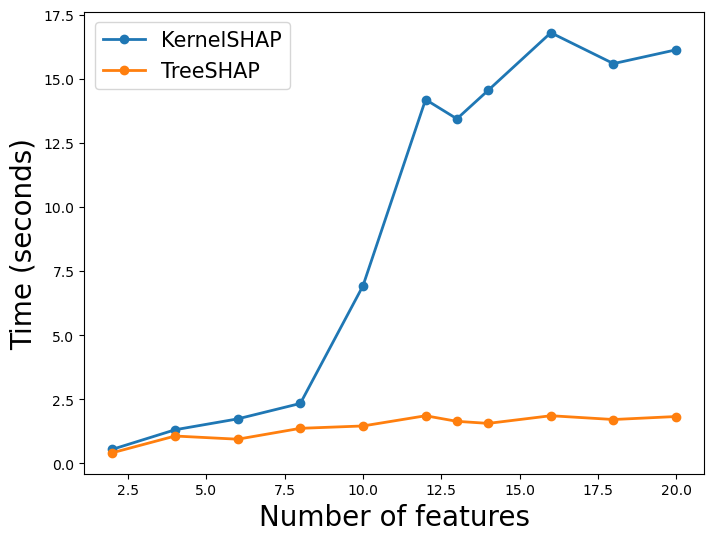

In [13]:
# Get average run time
avg_2 = results_2[['n_features','kernelSHAP','treeSHAP']].groupby(by='n_features',as_index=False).mean()

k_sec = [t.total_seconds() for t in avg_2['kernelSHAP']]
t_sec = [t.total_seconds() for t in avg_2['treeSHAP']]
n = avg_2['n_features']

print((k_sec/n)/(t_sec/n))

# Plot run time by number of features
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(8,6))

plt.plot(n, k_sec, linestyle='-', linewidth=2,marker='o',label = 'KernelSHAP')
plt.plot(n, t_sec, linestyle='-', linewidth=2,marker='o',label = 'TreeSHAP')

plt.ylabel('Time (seconds)',size=20)
plt.xlabel('Number of features',size=20)
plt.legend(fontsize=15)

plt.savefig(path.format('n_features_1.png'),dpi=100,bbox_inches='tight')

### Experiment 3: number of trees

In [14]:
# Simulate regression data
data = ds.make_regression(n_samples=10000, n_features=10, n_informative=8, n_targets=1)

y= data[1]
X = data[0]

feature_names = range(len(X))

In [15]:
results = []

for trees in [10,20,50,100,200,500,1000]*3:
    # Train model
    model = RandomForestRegressor(n_estimators=trees,max_depth=4,random_state=0)
    model.fit(X, y)
    
    # Get shap estimators
    kernelSHAP = shap.KernelExplainer(model.predict,shap.sample(X, 10))
    treeSHAP = shap.TreeExplainer(model)
    
    # Calculate SHAP Values
    kernel_time = runSHAP(n=100)
    tree_time = runSHAP(n=100,kernel=False)
    
    result = [trees,kernel_time,tree_time]
    results.append(result)

results_3 = pd.DataFrame(results,columns = ['trees','kernelSHAP','treeSHAP'])

  0%|          | 0/100 [00:00<?, ?it/s]

Kernel 100:  0:00:03.732274
Tree 100:  0:00:00.006087


  0%|          | 0/100 [00:00<?, ?it/s]

Kernel 100:  0:00:03.249358
Tree 100:  0:00:00.005128


  0%|          | 0/100 [00:00<?, ?it/s]

Kernel 100:  0:00:03.732728
Tree 100:  0:00:00.006162


  0%|          | 0/100 [00:00<?, ?it/s]

Kernel 100:  0:00:03.895003
Tree 100:  0:00:00.010204


  0%|          | 0/100 [00:00<?, ?it/s]

Kernel 100:  0:00:05.694955
Tree 100:  0:00:00.020094


  0%|          | 0/100 [00:00<?, ?it/s]

Kernel 100:  0:00:09.667769
Tree 100:  0:00:00.050276


  0%|          | 0/100 [00:00<?, ?it/s]

Kernel 100:  0:00:15.445090
Tree 100:  0:00:00.091514


  0%|          | 0/100 [00:00<?, ?it/s]

Kernel 100:  0:00:02.682685
Tree 100:  0:00:00.003107


  0%|          | 0/100 [00:00<?, ?it/s]

Kernel 100:  0:00:02.768781
Tree 100:  0:00:00.005405


  0%|          | 0/100 [00:00<?, ?it/s]

Kernel 100:  0:00:03.383986
Tree 100:  0:00:00.005947


  0%|          | 0/100 [00:00<?, ?it/s]

Kernel 100:  0:00:03.987076
Tree 100:  0:00:00.010674


  0%|          | 0/100 [00:00<?, ?it/s]

Kernel 100:  0:00:04.889593
Tree 100:  0:00:00.020356


  0%|          | 0/100 [00:00<?, ?it/s]

Kernel 100:  0:00:09.224168
Tree 100:  0:00:00.047379


  0%|          | 0/100 [00:00<?, ?it/s]

Kernel 100:  0:00:15.605691
Tree 100:  0:00:00.087472


  0%|          | 0/100 [00:00<?, ?it/s]

Kernel 100:  0:00:02.702818
Tree 100:  0:00:00.005530


  0%|          | 0/100 [00:00<?, ?it/s]

Kernel 100:  0:00:02.726887
Tree 100:  0:00:00.004119


  0%|          | 0/100 [00:00<?, ?it/s]

Kernel 100:  0:00:03.487658
Tree 100:  0:00:00.006257


  0%|          | 0/100 [00:00<?, ?it/s]

Kernel 100:  0:00:03.862023
Tree 100:  0:00:00.010630


  0%|          | 0/100 [00:00<?, ?it/s]

Kernel 100:  0:00:05.508119
Tree 100:  0:00:00.022455


  0%|          | 0/100 [00:00<?, ?it/s]

Kernel 100:  0:00:09.572319
Tree 100:  0:00:00.045794


  0%|          | 0/100 [00:00<?, ?it/s]

Kernel 100:  0:00:15.946002
Tree 100:  0:00:00.090557


0    619.245925
1    596.848485
2    577.391375
3    372.757570
4    255.828977
5    198.429082
6    174.358565
Name: trees, dtype: float64


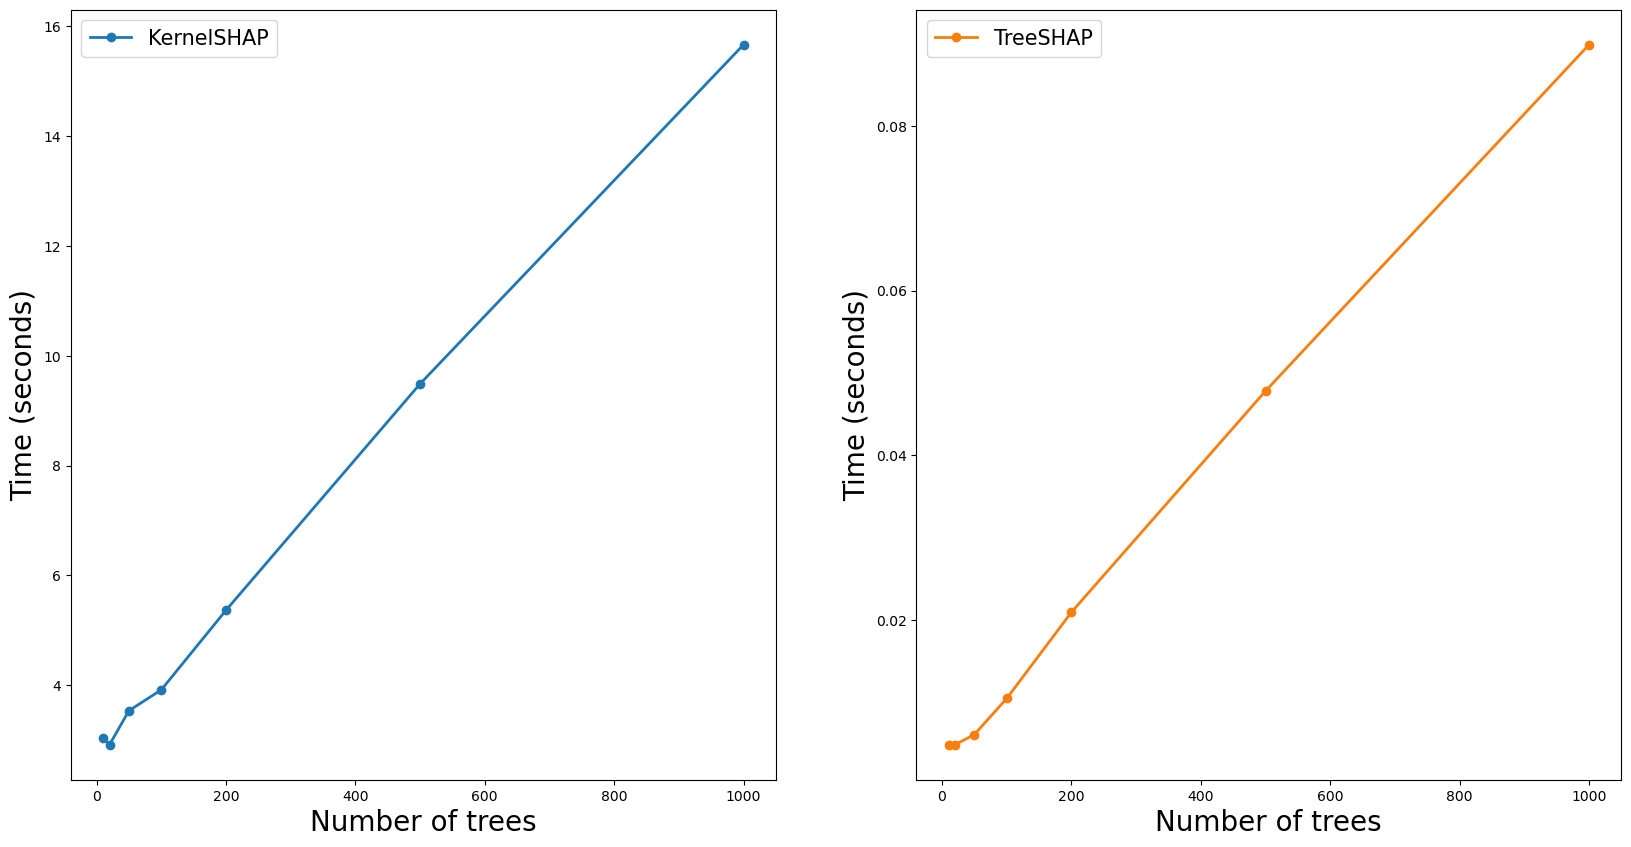

In [17]:
# Get average run time
avg_3 = results_3.groupby(by='trees',as_index=False).mean()

k_sec = [t.total_seconds() for t in avg_3['kernelSHAP']]
t_sec = [t.total_seconds() for t in avg_3['treeSHAP']]
trees = avg_3['trees']

print((k_sec/trees)/(t_sec/trees))

# 3Plot 
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(20,10))

ax[0].plot(trees, k_sec, linestyle='-', linewidth=2,marker='o',label = 'KernelSHAP')
ax[0].set_ylabel('Time (seconds)',size=20)
ax[0].set_xlabel('Number of trees',size=20)
ax[0].legend(fontsize=15)

ax[1].plot(trees, t_sec, color='#F87F0E', linewidth=2,marker='o',label = 'TreeSHAP')
ax[1].set_ylabel('Time (seconds)',size=20)
ax[1].set_xlabel('Number of trees',size=20)
ax[1].legend(fontsize=15)

plt.savefig(path.format('n_trees_1.png'),dpi=100,bbox_inches='tight')

### Experiment 4: tree depth

In [18]:
# Simulate regression data
data = ds.make_regression(n_samples=10000, n_features=10, n_informative=8, n_targets=1)

y= data[1]
X = data[0]

feature_names = range(len(X))

results = []

# for depth in [2,4,6]:
for depth in [2,4,6,8,10,15,20]*3:

    # Train model
    model = RandomForestRegressor(n_estimators=100,max_depth=depth,random_state=0)
    model.fit(X, y)
    
    # get model properties
    avg_depth, avg_feat, avg_leaves = model_properties(model)
    
    # Get shap estimators
    kernelSHAP = shap.KernelExplainer(model.predict,shap.sample(X, 10))
    treeSHAP = shap.TreeExplainer(model)
    
    kernel_time = runSHAP(n=100)
    tree_time = runSHAP(n=100,kernel=False)
    result = [depth, avg_depth, avg_feat, avg_leaves, kernel_time,tree_time]
    results.append(result)

results_4 = pd.DataFrame(results,columns = ['depth','avg_depth', 'avg_feat', 'avg_leaves','kernelSHAP','treeSHAP'])

  0%|          | 0/100 [00:00<?, ?it/s]

Kernel 100:  0:00:04.950316
Tree 100:  0:00:00.005300


  0%|          | 0/100 [00:00<?, ?it/s]

Kernel 100:  0:00:05.508895
Tree 100:  0:00:00.012534


  0%|          | 0/100 [00:00<?, ?it/s]

Kernel 100:  0:00:04.984991
Tree 100:  0:00:00.048929


  0%|          | 0/100 [00:00<?, ?it/s]

Kernel 100:  0:00:05.784611
Tree 100:  0:00:00.304080


  0%|          | 0/100 [00:00<?, ?it/s]

Kernel 100:  0:00:07.129336
Tree 100:  0:00:01.156024


  0%|          | 0/100 [00:00<?, ?it/s]

Kernel 100:  0:00:12.890560
Tree 100:  0:00:10.525434


  0%|          | 0/100 [00:00<?, ?it/s]

Kernel 100:  0:00:14.213404
Tree 100:  0:00:13.788352


  0%|          | 0/100 [00:00<?, ?it/s]

Kernel 100:  0:00:04.418118
Tree 100:  0:00:00.004370


  0%|          | 0/100 [00:00<?, ?it/s]

Kernel 100:  0:00:04.931580
Tree 100:  0:00:00.015244


  0%|          | 0/100 [00:00<?, ?it/s]

Kernel 100:  0:00:06.456688
Tree 100:  0:00:00.072948


  0%|          | 0/100 [00:00<?, ?it/s]

Kernel 100:  0:00:07.558840
Tree 100:  0:00:00.331467


  0%|          | 0/100 [00:00<?, ?it/s]

Kernel 100:  0:00:07.094363
Tree 100:  0:00:01.367669


  0%|          | 0/100 [00:00<?, ?it/s]

Kernel 100:  0:00:18.687951
Tree 100:  0:00:13.967406


  0%|          | 0/100 [00:00<?, ?it/s]

Kernel 100:  0:00:20.572608
Tree 100:  0:00:14.179020


  0%|          | 0/100 [00:00<?, ?it/s]

Kernel 100:  0:00:05.017628
Tree 100:  0:00:00.003505


  0%|          | 0/100 [00:00<?, ?it/s]

Kernel 100:  0:00:04.961793
Tree 100:  0:00:00.011461


  0%|          | 0/100 [00:00<?, ?it/s]

Kernel 100:  0:00:05.283226
Tree 100:  0:00:00.059458


  0%|          | 0/100 [00:00<?, ?it/s]

Kernel 100:  0:00:07.122062
Tree 100:  0:00:00.392771


  0%|          | 0/100 [00:00<?, ?it/s]

Kernel 100:  0:00:06.558045
Tree 100:  0:00:01.135936


  0%|          | 0/100 [00:00<?, ?it/s]

Kernel 100:  0:00:10.957567
Tree 100:  0:00:07.824375


  0%|          | 0/100 [00:00<?, ?it/s]

Kernel 100:  0:00:10.085678
Tree 100:  0:00:11.409213


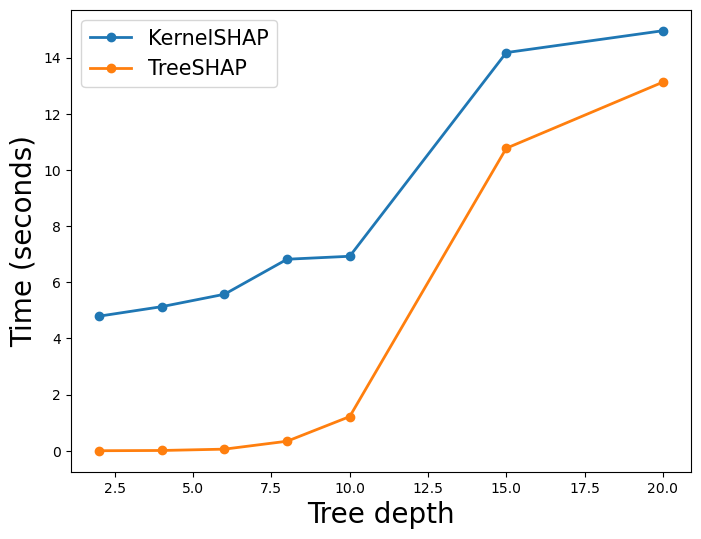

In [19]:
avg_4 = results_4[['depth','kernelSHAP','treeSHAP']].groupby(by='depth',as_index=False).mean()

# Tree Depth
k_sec = [t.total_seconds() for t in avg_4['kernelSHAP']]
t_sec = [t.total_seconds() for t in avg_4['treeSHAP']]
depth = avg_4['depth']

fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(8,6))

plt.plot(depth, k_sec, linestyle='-', linewidth=2,marker='o',label = 'KernelSHAP')
plt.plot(depth, t_sec, linestyle='-', linewidth=2,marker='o',label = 'TreeSHAP')
plt.legend(fontsize=15)

plt.ylabel('Time (seconds)',size=20)
plt.xlabel('Tree depth',size=20)

plt.savefig(path.format('tree_depth.png'),dpi=100,bbox_inches='tight')

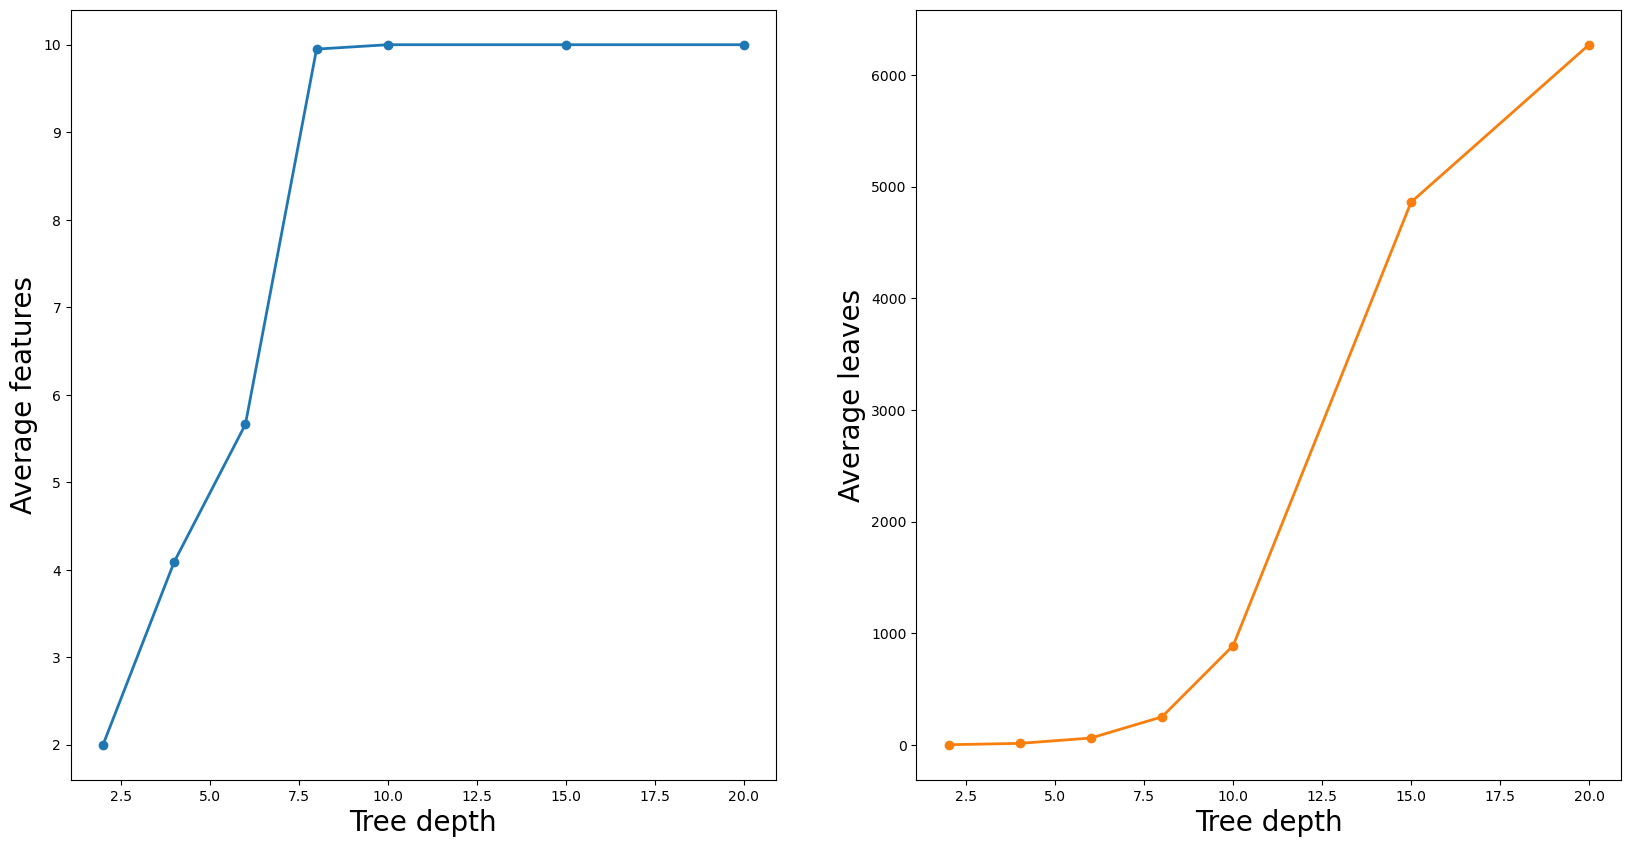

In [20]:
# Other factors
r4 = results_4[['depth','avg_depth','avg_feat','avg_leaves']].groupby(by='depth',as_index=False).mean()


fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(20,10))

ax[0].plot(r4['depth'], r4['avg_feat'], linestyle='-', linewidth=2,marker='o')
ax[0].set_ylabel('Average features',size=20)
ax[0].set_xlabel('Tree depth',size=20)

ax[1].plot(r4['depth'], r4['avg_leaves'], color='#F87F0E', linewidth=2,marker='o')
ax[1].set_ylabel('Average leaves',size=20)
ax[1].set_xlabel('Tree depth',size=20)

plt.savefig(path.format('other_factors.png'),dpi=100,bbox_inches='tight')

## Archive 

In [21]:
#
data = ds.make_regression(n_samples=10000, n_features=10, n_informative=8, n_targets=1)

y= data[1]
X = data[0]

feature_names = range(len(X))

depth = 10 # vary this value 
model = RandomForestRegressor(n_estimators=100,max_depth=depth,random_state=0)
model.fit(X, y)

model_properties(model)

(10.0, 10.0, 882.53)

In [22]:
# Simulate regression data
data = ds.make_regression(n_samples=10000, n_features=20, n_informative=20, n_targets=1,noise=0.1)

y= data[1]
X = data[0]

feature_names = range(len(X))

# Train model
model = RandomForestRegressor(n_estimators=100,max_depth=10,random_state=0)
model.fit(X, y)

# get model properties
avg_depth, avg_feat, avg_leaves = model_properties(model)


# Get shap estimators
treeSHAP = shap.TreeExplainer(model)
kernelSHAP = shap.KernelExplainer(model.predict,shap.sample(X, 20))

# get shap values 
x_sample = X[np.random.choice(X.shape[0], 100, replace=True)]
sv_tree = treeSHAP.shap_values(x_sample)
sv_kernel = kernelSHAP.shap_values(x_sample,l1_reg=0.1)

print(len(sv_tree[0]),len(sv_kernel[0]))

  0%|          | 0/100 [00:00<?, ?it/s]

20 20
